In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#put indicator index into one dataframe
df_indicator = pd.read_excel('Data2.0.xlsx', sheet_name= 'Indicators')
df_indicator = df_indicator.set_index('Dates')
df_indicator=df_indicator.rename(columns={'SPX Index':'S&P500'})
df_indicator
#put Monthly Instrument into one dataframe
df_instrument_1=pd.read_excel('Data2.0.xlsx', sheet_name= 'Instruments')
df_instrument_1 = df_instrument_1.set_index('Dates')
df_instrument_1=df_instrument_1.rename(columns={'M1USMMT Index':'MSCI US Momentum index',
                              'M1USQU Index':'MSCI US Quality index',
                              'M00IMV$T Index':'MSCI US Min Vol index',
                              'M1US000V Index':'MSCI US Value index',
                              'M1US000G Index':'MSCI US Growth index',
                              'RTY Index':'Russell 2000',
                              'LBUSTRUU Index':'US IG corporate bonds index',
                              'SPGSCI Index':'GSCI commodity index'})
df_instrument_1
#df_logReturn = df_instrument_1.applymap(lambda x: np.log(float(x))) - df_instrument_1.shift().applymap(lambda x: np.log(float(x)))

#clean the US 10Y and 3_month bond data
df_Bond = pd.read_excel('Data2.0.xlsx', sheet_name= 'Bonds')
df_Bond = df_Bond.set_index('Dates')
df_Bond=df_Bond.rename(columns={'SPBDU1BT Index':'US 10-year Treasury Bond Index',
                              'SPBDUB3T Index':'US 3-month T-bill Index'})


df_instrument= df_instrument_1.merge(df_Bond, left_index=True, right_index=True, how = 'left')


df_logReturn = df_instrument.applymap(lambda x: np.log(float(x))) - df_instrument.shift().applymap(lambda x: np.log(float(x)))
df_logReturn
#df_instrument_yearly log return
df_instrument_yearly = df_instrument.resample('Y').ffill()
df_instrument_Q = df_instrument.resample('Q').ffill()
df_instrument_6M = df_instrument.resample('6M').ffill()

#df_instrument_yearly = df_instrument_yearly.merge(df_10YBond, left_index=True, right_index=True, how = 'left')
#df_instrument_yearly = df_instrument_yearly.merge(df_3MBond, left_index=True, right_index=True, how = 'left')
df_logReturnYearly = df_instrument_yearly.applymap(lambda x: np.log(float(x))) - df_instrument_yearly.shift().applymap(lambda x: np.log(float(x)))
df_logReturnQ = df_instrument_Q.applymap(lambda x: np.log(float(x))) - df_instrument_Q.shift().applymap(lambda x: np.log(float(x)))
df_logReturn6m = df_instrument_6M.applymap(lambda x: np.log(float(x))) - df_instrument_6M.shift().applymap(lambda x: np.log(float(x)))
#df_logReturnYearly


############ Regime Finding ##########
import matplotlib.pyplot as plt
df_used = df_logReturn.merge(df_indicator, left_index = True, right_index = True, how = 'left').dropna()
df_used['CPI'] = df_used['CPI'].pct_change()
df_used['PMI'] = df_used['PMI'].pct_change()
df_used['S&P500'] = df_used[['S&P500']].applymap(lambda x: np.log(float(x))) - df_used[['S&P500']].shift().applymap(lambda x: np.log(float(x)))

import warnings
warnings.filterwarnings("ignore")
df_used = df_used.dropna()

# Market Regime

<p style="font-size: 20px; font-weight: bold;">Part 1: Generate Nine Indicator for market regime.</b>

In [30]:
#import plotly.express as px
df_features = df_used[['US 3-month T-bill Index', 'S&P500', 'VIX Index']].ewm(span = 5).mean()
df_features.loc[:, 'S&P500_Change'] = df_features['S&P500'].diff(3)
df_features.loc[:, 'S&P500_Last'] = df_features['S&P500'].shift()
df_features.loc[:, 'T3_Change'] = df_features['US 3-month T-bill Index'].diff(3)
df_features.loc[:, 'VIX_Change'] = df_features['VIX Index'].diff(3)
df_features.loc[:, 'CPI_PMI'] = df_used['CPI'] + df_used['PMI']
df_features.loc[:, 'CPI_PMI_Change'] = df_features['CPI_PMI'].diff(3)
df_features = df_features.shift(1).dropna()

<p style="font-size: 20px; font-weight: bold;">Part 2: Split data into training, testing data.</b>

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
indices = df_features.index

# randomly Split indices into training (80%), and testing (20%)
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=3)

# Use the indices to subset the original DataFrame
train_df = df_features.loc[train_indices].sort_index()
test_df = df_features.loc[test_indices].sort_index()

 <p style="font-size: 20px; font-weight: bold;">Part 3: Standardized Indicators of market regimes.</b>

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_train = pd.DataFrame(scaled_train, columns=train_df.columns, index = train_df.index)
scaled_train

,US 3-month T-bill Index,S&P500,VIX Index,S&P500_Change,S&P500_Last,T3_Change,VIX_Change,CPI_PMI,CPI_PMI_Change
Dates,,,,,,,,,
1995-08-31,1.638586,1.126296,-1.190366,0.053796,0.962208,1.179463,0.218007,-0.175344,-0.168087
1995-09-29,1.618331,0.559202,-1.251336,-0.650336,1.048025,-0.575219,-0.066859,-0.305657,-0.001322
1995-10-31,1.499222,0.961245,-1.219877,-0.065653,0.503118,-0.871236,0.119561,0.456081,0.544137
1995-11-30,1.566183,0.412761,-1.142348,-0.617806,0.889431,-0.359800,0.082877,-0.234450,-0.001193
1995-12-29,1.487957,0.861283,-1.210956,0.261435,0.362407,-0.669023,0.069317,-0.092076,0.197398
...,...,...,...,...,...,...,...,...,...
2023-03-31,0.703925,-0.323745,0.197861,-0.690818,0.304777,2.923286,-0.820462,-0.420607,1.905464
2023-04-28,0.929730,0.255092,0.043029,0.933383,-0.345283,2.438459,-0.812721,-0.164878,-1.234788
2023-05-31,0.962775,0.304267,-0.206945,-0.042086,0.210907,2.114000,-0.865548,-1.069458,-0.755768


In [33]:
scaled_test = pd.DataFrame(scaler.transform(test_df), columns = test_df.columns, index = test_df.index)

 <p style="font-size: 20px; font-weight: bold;">Part 4: K Means to Cluster 4 Market Regime.</b>

PC1: 0.3231
PC2: 0.1941
PC3: 0.1401
PC4: 0.1114
PC5: 0.0833
PC6: 0.0560
PC7: 0.0409
PC8: 0.0327
PC9: 0.0184


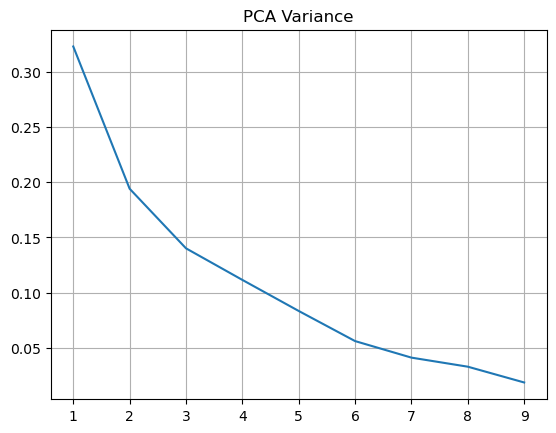

In [34]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(scaled_train)

# Create a DataFrame from the PCA results
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
for i, explained_var in enumerate(explained_variance_ratio):
    print(f'PC{i+1}: {explained_var:.4f}')

# The resulting DataFrame X_pca_df contains the principal components
# You can use this DataFrame for further analysis or visualization
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio)
plt.grid()
plt.title('PCA Variance')
plt.show()

In [35]:
scaled_pc = pd.DataFrame(pca.transform(scaled_train), columns = pca_columns, index = scaled_train.index).iloc[:, :6]
scaled_pc

,PC1,PC2,PC3,PC4,PC5,PC6
Dates,,,,,,
1995-08-31,-1.226555,-1.673566,-1.082703,1.352537,0.433338,-0.237240
1995-09-29,-0.737626,-1.136632,-0.663983,1.525579,-1.206919,-0.463190
1995-10-31,-1.086477,-0.070240,-0.817765,1.563637,-0.947983,-0.955416
1995-11-30,-0.540419,-1.071810,-0.777391,1.425641,-0.972433,-0.411298
1995-12-29,-0.904564,-0.460177,-0.365894,1.564953,-0.535154,-1.086736
...,...,...,...,...,...,...
2023-03-31,-0.528292,-0.573714,-2.063380,-0.188299,1.881387,1.442143
2023-04-28,-0.565716,-1.561877,-0.005786,0.361331,2.410580,0.620129
2023-05-31,-0.417828,-2.090534,-0.164453,0.388005,1.543917,0.720029


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


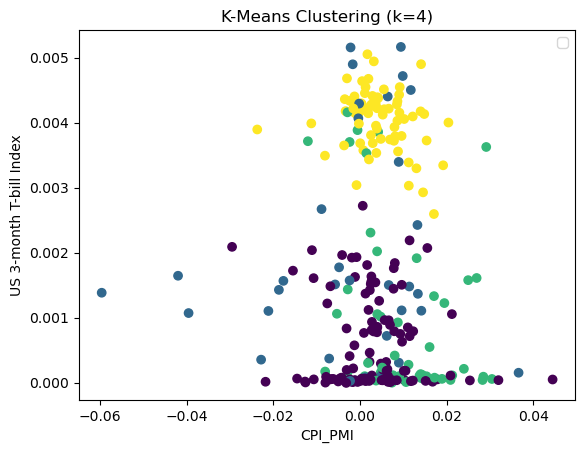

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Number of clusters
k = 4

# Fit K-Means model
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(scaled_pc)

# Add cluster labels to the DataFrame
train_df['Cluster'] = kmeans.labels_

# Visualize the clusters (for 2D data)
plt.scatter(train_df['CPI_PMI'], train_df['US 3-month T-bill Index'], c=train_df['Cluster'], cmap='viridis')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.xlabel('CPI_PMI')
plt.ylabel('US 3-month T-bill Index')
plt.title('K-Means Clustering (k=4)')
plt.legend()
plt.show()

In [37]:
df_instrument['Cluster'] = train_df['Cluster']

<p style="font-size: 20px; font-weight: bold;">Part 5: Different Market Regime on SP500 Price Trend Chart.</b>

In [38]:
import plotly.express as px
fig = px.scatter(df_instrument.loc[train_df.index], x=train_df.index, y=df_indicator.loc[train_df.index, 'S&P500'], color = 'Cluster')

# Customize the plot
#fig.update_traces(textposition='top center', textfont_size=10)

# Set axis labels and plot title
fig.update_layout(xaxis_title='Time', yaxis_title='S&P500', title='Scatter Plot of S&P500')

# Show the plot
fig.show()

In [39]:
regimeDic = {2:'SlowDown', 3:'Contraction', 0:'Expansion', 1:'Recovery'}

<p style="font-size: 20px; font-weight: bold;">Part 6: Assets Performence under Each Regime.</b>

In [40]:
def getRegimeInfo(df_logReturn, train_df):
    df_out_all = pd.DataFrame()
    for regime in range(4):
        df = df_logReturn.loc[train_df[train_df['Cluster'] == regime].index]
        df['Benchmark'] = df.mean(axis = 1)
        mean_r = 12*df.dropna().mean()
        sigma_r = np.sqrt(12)*df.dropna().std()
        mean_r_rm = 12*df.sub(df['Benchmark'], axis = 0).dropna().mean()
        sigma_r_rm = np.sqrt(12)*df.sub(df['Benchmark'], axis = 0).dropna().std()
        sharpe_ratio = (mean_r)/ (sigma_r)
        info_ratio = (mean_r_rm)/ (sigma_r_rm)
        df_out = pd.DataFrame(columns = df.columns)
        df_out.loc['Mean Return'] = mean_r
        df_out.loc['Return Std'] = sigma_r
        df_out.loc['Mean Excess Return'] = mean_r_rm
        df_out.loc['Info Std'] = sigma_r_rm
        df_out.loc['Sharpe Ratio'] = sharpe_ratio
        df_out.loc['Info Ratio'] = info_ratio
        df_out['Regime'] = regimeDic[regime]
        df_out_all = pd.concat((df_out_all, df_out))
    return df_out_all.fillna(0)

regimeDf = getRegimeInfo(df_logReturn, train_df)

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 2 rows and 2 columns
fig = make_subplots(rows=1, cols=4, subplot_titles=['Expansion', 'SlowDown', 'Contraction', 'Recovery'])

for i, regime_name in enumerate(['Expansion', 'SlowDown', 'Contraction', 'Recovery']):
    info_ratio = regimeDf[regimeDf['Regime'] == regime_name].loc[['Info Ratio']].drop(['Benchmark', 'Regime'], axis=1)
    
    # Add a bar trace to the subplot
    trace = go.Bar(x=info_ratio.columns, y=info_ratio.loc['Info Ratio'], name='Info Ratio')
    row = 1 
    col = i + 1
    fig.add_trace(trace, row=row, col=col)
fig.update_layout(width=1200, height=600)
# Update layout
fig.update_layout(title_text='Info Ratio of Different Regimes', showlegend=False)

# Show the plot
fig.show()
